In [1]:
def Runmodel_Getcriticalvolume(minerals, modal_mineralogy, csds_means, csds_stds, deviation, optlearnvalue):
    optiprv = 1e9
    lower_bound =  modal_mineralogy-(deviation*modal_mineralogy)
    upper_bound =  modal_mineralogy+(deviation*modal_mineralogy)
    counter = 0
    highest_false = 0
    lowest_true = 1e9
    par_rock_new = (lowest_true + highest_false)/2
    while counter != 11: 
        learnrate = optlearnvalue / par_rock_new
        print("Parent rock volume:", par_rock_new)
        print("Learnrate:", learnrate)
        model = SedGen(minerals, par_rock_new, modal_mineralogy, csds_means, csds_stds, learning_rate = learnrate, discretization_init = False, timed=True)
        print("Model volume ratio:", np.sum(model.simulated_volume)/par_rock_new)
        print("Simulated volume:", np.sum(model.simulated_volume), "\n")
        proposition1 = model.simulated_volume/par_rock_new >= lower_bound
        proposition2 = model.simulated_volume/par_rock_new <= upper_bound
        if np.all(proposition1 == True) and np.all(proposition2 == True):
            lowest_true = par_rock_new
            par_rock_new = (highest_false + lowest_true)/2
            counter += 1
        else: 
            highest_false = par_rock_new
            par_rock_new = (highest_false + lowest_true)/2
            counter += 1
    print(par_rock_new)
    return par_rock_new

In [2]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [3]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [6]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])  # WA

csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

csds_CA_EW_means = np.array([0.247, 0.333, 0.292, 0.212, 0.090, 0.127])
csds_CA_EW_stds = np.array([0.986, 0.640, 0.497, 0.889, 0.275, 0.502])

csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

csds_GR_means = np.array([0.244, 0.269, 0.222, 0.251, 0.059, 0.107])
csds_GR_stds = np.array([0.312, 0.450, 0.444, 0.262, 0.378, 0.313])

csds_MT_means = np.array([0.220, 0.227, 0.160, 0.153, 0.078, 0.075])
csds_MT_stds = np.array([0.472, 0.415, 0.344, 0.363, 0.315, 0.599])

csds_WA_means = np.array([0.342, 0.385, 0.241, 0.481, 0.001, 0.130])
csds_WA_stds = np.array([0.542, 0.478, 0.386, 0.467, 0.001, 0.494])




In [7]:
%%time
# critical_volume_AZ = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, deviation = 0.05, optlearnvalue = 5e11)
# critical_volume_CA_EW = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds, deviation = 0.05, optlearnvalue = 8e12)
# critical_volume_CA_NS = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, deviation = 0.05, optlearnvalue = 8e12)
# critical_volume_GR = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[3], csds_GR_means, csds_GR_stds, deviation = 0.05, optlearnvalue = 5e11)
# critical_volume_MT = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[4], csds_MT_means, csds_MT_stds, deviation = 0.05, optlearnvalue = 5e11)
critical_volume_WA = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[5], csds_WA_means, csds_WA_stds, deviation = 0.025, optlearnvalue = 1e12)


Parent rock volume: 500000000.0
Learnrate: 2000.0
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|250001, 212337, 181210, 154011, 130844, 111212, 94475, 80831, 69060, 58928, 50428, 42814, 36406, 30966, 26735, 22546, 19435, 16253, 13813, 11883, 10187, 8600, 7402, 6185, 5248, 4544, 3809, 3122, 2637, 2226, 1889, 1598, 1440, 1184, 992, 824, 684, 585, 506, 436, 323, 292, 253, 242, 158, 147, 122, 116, 112, 102, 93, 79, 79, 77, 76, 56, 53, 44, 38, 38, 37, 25, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, P|250001, 234595, 220641, 206937, 194112, 182166, 171066, 160727, 150790, 141703, 132936, 124873, 117231, 110060, 103634, 97096, 91088, 85733, 80347, 75651, 71017,

In [14]:
%%time
# critical_volume_AZ = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, deviation = 0.05, optlearnvalue = 5e11)
# critical_volume_CA_EW = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds, deviation = 0.05, optlearnvalue = 8e12)
# critical_volume_CA_NS = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, deviation = 0.05, optlearnvalue = 8e12)
# critical_volume_GR = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[3], csds_GR_means, csds_GR_stds, deviation = 0.05, optlearnvalue = 5e11)
# critical_volume_MT = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[4], csds_MT_means, csds_MT_stds, deviation = 0.05, optlearnvalue = 5e11)
critical_volume_WA = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[5], csds_WA_means, csds_WA_stds, deviation = 0.025, optlearnvalue = 1e12)


Parent rock volume: 500000000.0
Learnrate: 2000.0
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 4.5408 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 9.5134 seconds
Counting interfaces...  Done in 0.0955 seconds
Correcting interface arrays for consistency...
too much Q 2
all good P 0
all good K 0
all good B 0
all good O 0
too few A -2
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.7303 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
Model volume ratio: 1.00004598268888
Simulated volume: 500022991.34444 

Parent rock volume: 250000000.0
Learnrate: 4000.0
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 2.695

In [8]:
%%time
# critical_volume_AZ = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, deviation = 0.05, optlearnvalue = 5e11)
# critical_volume_CA_EW = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds, deviation = 0.05, optlearnvalue = 8e12)
# critical_volume_CA_NS = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, deviation = 0.05, optlearnvalue = 8e12)
# critical_volume_GR = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[3], csds_GR_means, csds_GR_stds, deviation = 0.05, optlearnvalue = 5e11)
# critical_volume_MT = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[4], csds_MT_means, csds_MT_stds, deviation = 0.05, optlearnvalue = 5e11)
critical_volume_WA = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[5], csds_WA_means, csds_WA_stds, deviation = 0.05, optlearnvalue = 1e12)


---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 21.1451 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 41.1350 seconds
Counting interfaces...  Done in 0.4327 seconds
Correcting interface arrays for consistency...
too much Q 4
all good P 0
all good K 0
too few B -2
too few O -1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 3.4532 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 10.7455 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 19.6049 seconds
Counting interfaces...  Done in 0.2362 seconds
Correcting interface arrays for consistency...
t

In [8]:
print(critical_volume_AZ,critical_volume_CA_EW,critical_volume_CA_NS,critical_volume_GR,critical_volume_MT,critical_volume_WA)


1708984.375 1708984.375 3173828.125 244140.625 1220703.125 244140.625


In [9]:
weightedmeanAZ = np.sum(modal_mineralogy[0]*csds_AZ_means)
weightedmeanCA_EW = np.sum(modal_mineralogy[1]*csds_CA_EW_means)
weightedmeanCA_NS = np.sum(modal_mineralogy[2]*csds_CA_NS_means)
weightedmeanGR = np.sum(modal_mineralogy[3]*csds_GR_means)
weightedmeanMT = np.sum(modal_mineralogy[4]*csds_MT_means)
weightedmeanWA = np.sum(modal_mineralogy[5]*csds_WA_means)

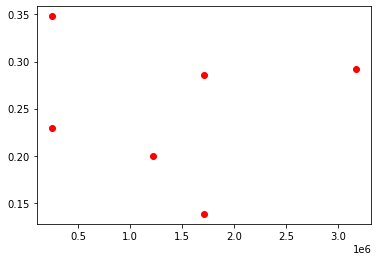

In [10]:
yaxis = np.array([weightedmeanAZ,weightedmeanCA_EW,weightedmeanCA_NS,weightedmeanGR,weightedmeanMT,weightedmeanWA])
xaxis = np.array([critical_volume_AZ,critical_volume_CA_EW,critical_volume_CA_NS,critical_volume_GR,critical_volume_MT,critical_volume_WA])
plt.plot(xaxis, yaxis, 'ro')